In [262]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import pprint

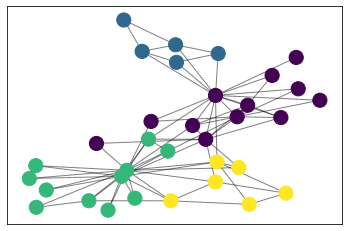

In [263]:
G=nx.Graph()
gr=pd.read_csv('karate.csv')
#gr=pd.read_csv('dolphin.csv')
#gr=pd.read_csv('football.csv')
edge=[(gr['Source'][i],gr['Destination'][i]) for i in range(0,len(gr['Source']))]
G.add_edges_from(edge)
node=max([max(x[0],x[1]) for x in edge])
# compute the best partition
# partition contains color of each node
partition = community_louvain.best_partition(G)

# visualization of clusters
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=200,cmap=cmap, node_color=list(partition.values()),)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [264]:
# Generating gateEdges
# gateEdges contains edges--> [(a,b),(b,c)]
gateEdges=[]
for x in edge:
    if(partition[x[0]]!=partition[x[1]]):
        gateEdges.append(x)

# Generating gate nodes 
gateNodesDict={}

for tup in gateEdges:
    gateNodesDict[tup[0]]=1
    gateNodesDict[tup[1]]=1

gateNodesList=list(gateNodesDict.keys())

print("Gateway graph nodes:",gateNodesList)
for x in gateNodesList:
    for y in gateNodesList:
        if(x==y or ((x,y) in gateEdges) or ((y,x) in gateEdges)):
            continue
        else:
            if(partition[x]==partition[y]):
                if((x,y) in edge or (y,x) in edge):
                    gateEdges.append((x,y))

Gateway graph nodes: [5, 1, 6, 7, 9, 3, 11, 28, 29, 30, 24, 31, 2, 32, 33, 34, 10, 14, 20]


In [265]:
# Gate graph
# This is the gate way graph
# gate
tot_g=[]
for i in range(0,500):
    g = nx.Graph()
    tot_g.append(g)
    attr = {(u, v): {"weight": round(random.uniform(0,1),2)} for (u, v) in g.edges()}
    nx.set_edge_attributes(g, attr)

for k in range(0,500):
    tot_g[k].add_nodes_from(gateNodesList)
    for i in range(0,len(gateEdges)):
        tot_g[k].add_edge(gateEdges[i][0],gateEdges[i][1],weight=round(random.uniform(0,1),2))

In [266]:
#BCS Score
def BCS(G,nodes):
    BCS_=[0]*(nodes+1)
    for i in G:
        x=(nx.betweenness_centrality(i,weight='weight'))
        #print(x)
        for j in x:
            BCS_[j]+=(1/10)*x[j]
    #BCS_=[round(i,3) for i in BCS_]
    return BCS_
BCSSS=BCS(tot_g,max([max(a[0],a[1]) for a in gateEdges]))
BCS_value={}
for i in range(1,max([max(a[0],a[1]) for a in gateEdges])+1):
    BCS_value[i]=BCSSS[i]
BCS_value=(sorted(BCS_value.items(), key=lambda x: x[1],reverse=True))
print(BCS_value)

[(1, 22.552913943355183), (34, 16.5757026143791), (3, 12.487352941176473), (33, 7.805081699346394), (9, 6.161846405228749), (2, 5.6155827886710155), (32, 4.416285403050101), (14, 3.9804466230936737), (31, 3.0673202614379034), (20, 2.7630174291938956), (24, 2.2959150326797335), (11, 2.020343137254898), (6, 1.9323529411764673), (7, 1.8799836601307152), (29, 1.835642701525052), (5, 1.6077342047930254), (28, 1.4839869281045723), (30, 0.9468954248366005), (10, 0.5319716775599127), (4, 0), (8, 0), (12, 0), (13, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (21, 0), (22, 0), (23, 0), (25, 0), (26, 0), (27, 0)]


In [267]:
# Model selection - diffusion time
model = ep.SIModel(G)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.03)
cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)

#Mapping diffusion_time_to_each_node
time_of_diffusion={}
for i in range(1,node+1):
    time_of_diffusion[i]=-1
for i in iterations:
    for j in i['status']:
        if(i['status'][j]==1):
            time_of_diffusion[j]=i['iteration']

100%|██████████| 200/200 [00:00<00:00, 2666.76it/s]


In [268]:
print(time_of_diffusion)

{1: 10, 2: 33, 3: 47, 4: 28, 5: 0, 6: 16, 7: 22, 8: 18, 9: 59, 10: 58, 11: 5, 12: 20, 13: 31, 14: 49, 15: 72, 16: 113, 17: 19, 18: 55, 19: 65, 20: 22, 21: 95, 22: 24, 23: 58, 24: 59, 25: 66, 26: 89, 27: 59, 28: 69, 29: 63, 30: 64, 31: 63, 32: 65, 33: 63, 34: 57}


In [269]:
sensor_nodes=[BCS_value[i][0] for i in range(0,3)]
print(sensor_nodes)
print(gateNodesList)
print(len(gateEdges))

[1, 34, 3]
[5, 1, 6, 7, 9, 3, 11, 28, 29, 30, 24, 31, 2, 32, 33, 34, 10, 14, 20]
44


In [270]:
delta_t=[]
min_v=min([time_of_diffusion[i] for i in sensor_nodes])
min_n=-1
for i in sensor_nodes:
    if(time_of_diffusion[i]==min_v):
        min_n=i
        break
delta_t=[abs(time_of_diffusion[i]-min_v) for i in sensor_nodes if(i!=min_n)]
print(delta_t)

[47, 37]


In [271]:
timeOfDiffusions=[]
for i in tot_g:
    print(len(i.edges()))
    # Model selection - diffusion time
    model = ep.SIModel(i)

    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', 0.03)
    cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
    model.set_initial_status(cfg)

    # Simulation execution
    iterations = model.iteration_bunch(200)

    #Mapping diffusion_time_to_each_node
    time_of_diffusion={}
    for i in range(1,node+1):
        time_of_diffusion[i]=-1
    for i in iterations:
        for j in i['status']:
            if(i['status'][j]==1):
                time_of_diffusion[j]=i['iteration']
    timeOfDiffusions.append(len(time_of_diffusion))

  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


 96%|█████████▌| 192/200 [00:00<00:00, 1919.95it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 2795.69it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 4081.39it/s]


44
44
44

  0%|          | 0/200 [00:00<?, ?it/s]


44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


100%|██████████| 200/200 [00:00<00:00, 6251.01it/s]

44
44
44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


100%|██████████| 200/200 [00:00<00:00, 3571.37it/s]


44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


100%|██████████| 200/200 [00:00<00:00, 3448.14it/s]

44
44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


100%|██████████| 200/200 [00:00<00:00, 5714.19it/s]

44
44
44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


100%|██████████| 200/200 [00:00<00:00, 3704.10it/s]

44
44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


100%|██████████| 200/200 [00:00<00:00, 5884.18it/s]

44
44
44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


100%|██████████| 200/200 [00:00<00:00, 3333.46it/s]

44
44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


100%|██████████| 200/200 [00:00<00:00, 2531.72it/s]

44
44



100%|██████████| 200/200 [00:00<00:00, 4255.61it/s]

44
44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


100%|██████████| 200/200 [00:00<00:00, 4166.51it/s]

44
44
44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


100%|██████████| 200/200 [00:00<00:00, 2000.08it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


100%|██████████| 200/200 [00:00<00:00, 2666.64it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


100%|██████████| 200/200 [00:00<00:00, 2564.05it/s]

44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


100%|██████████| 200/200 [00:00<00:00, 3636.17it/s]

44
44
44



  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


100%|██████████| 200/200 [00:00<00:00, 4082.05it/s]


44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44
44


100%|██████████| 200/200 [00:00<00:00, 5716.02it/s]


44
44
44
44


  0%|          | 0/200 [00:00<?, ?it/s]

44
44
44
44


100%|██████████| 200/200 [00:00<00:00, 4348.52it/s]


In [272]:
for i in timeOfDiffusions:
    print(i)
print(len(gateNodesList))

34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
3

44


100%|██████████| 200/200 [00:00<00:00, 1639.29it/s]


100%|██████████| 200/200 [00:00<00:00, 3448.21it/s]


100%|██████████| 200/200 [00:00<00:00, 2667.00it/s]


[[8.964963334036965e-09, 5.50338494981144e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.112148443238177e-10, 6.232271013038e-10, 0.0, 7.529583543070909e-07, 0.0, 0.0, 0.0, 3.962435604088472e-09, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.904515563782839e-10, 0.0, 6.112148443238177e-10, 6.112148443238177e-10, 0.0, 3.1021393995054906e-08, 6.112148443238177e-10, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 3.316530357809765e-08, 0.0, 0.0, 0.0, 0.0, 7.314943015541313e-07, 0.0, 0.0, 1.6532047857322235e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9106543156718766e-06, 0.0, 0.0, 0.0], [1.2497585284390076e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0906806966643407e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.490972703482923e-10, 0.0, 0.0], [5.907087804469432e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7637837559590931e-31, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 2.84124569521442e-09, 0.0, 0.0, 0.0, 6.112148443238177e-10, 0.0, 0.0, 1.7587604189142703e-07, 0.0, 0.0, 7.

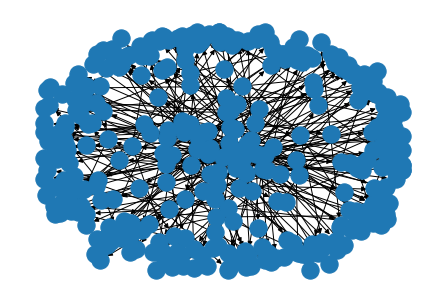

In [273]:
g__ = nx.Graph()
g__.add_edges_from(gateEdges)
print(len(gateEdges))
allDiffusionTime = []
mcaps=[tot_g[i] for i in random.sample(range(0, 500), 20)]
toTakeArgmax=[]
for node in gateNodesList:
#     print(node)
    bfs_tree = nx.bfs_tree(g__, source = node)
    nx.draw(bfs_tree)
    vecOfArgmax=[]
    for mcap in mcaps:
        model = ep.SIModel(bfs_tree)
        # Model Configuration
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', 0.03)
        cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in bfs_tree.edges()]))
        model.set_initial_status(cfg)

        # Simulation execution
        iterations = model.iteration_bunch(200)

        #Mapping diffusion_time_to_each_node
        
        time_of_diffusion={}
        for i in range(1,node+1):
            time_of_diffusion[i]=-1
        for i in iterations:
            for j in i['status']:
                if(i['status'][j]==1):
                    time_of_diffusion[j]=i['iteration']
        allDiffusionTime.append(time_of_diffusion)
        
        for node in gateNodesList:
            if node not in time_of_diffusion.keys(): 
                time_of_diffusion[node]=-1
        
        min_v=min([time_of_diffusion[i] for i in sensor_nodes])
        min_n=-1
        for i in sensor_nodes:
            if(time_of_diffusion[i]==min_v):
                min_n=i
                break
        mu=[abs(time_of_diffusion[i]+min_v)/2 for i in sensor_nodes if(i!=min_n)]
#         print(len(delta_t),len(mu))
        
        arrivals=[]
        
        for sensor in sensor_nodes:
            if(time_of_diffusion[sensor]==-1):
                arrivals.append(200)
            else:
                arrivals.append(time_of_diffusion[sensor])
                
#         print("arrivals",arrivals)
                
        new_delta_ts = []
            
        for i in range(0,len(arrivals)):
            new_delta_t=[]
            for j in range(0,len(arrivals)):
                if(i!=j):
                    new_delta_t.append(abs(arrivals[j]-arrivals[i]))
            new_delta_ts.append(new_delta_t)
#             print("new_delta_ts",new_delta_ts)
#         print(new_delta_ts)
            
        lambd = []
        for i in range(0,len(new_delta_ts)-1):
#             print("---> ",len(new_delta_ts[i]),len(new_delta_ts[i+1]))
            val = np.correlate(new_delta_ts[i],new_delta_ts[i+1],"same")
            for i in range(0,len(val)):
                if (val[i]==0):
                    val[i]=1
            lambd.append(val)
#         print("lambd",lambd)
#         print("delta_t",delta_t,"mu",mu)    
        sub = np.subtract(delta_t,mu)
#         print("sub",sub)
        lambd[0][1]=0
        powerOfe = np.dot(np.dot((sub), np.linalg.inv(lambd) ),np.transpose(sub))
#         print("powerOfe",powerOfe)
        powerOfe=abs(powerOfe)
        fun = (1/np.linalg.det(lambd))*np.exp(-(1/2)*powerOfe)
        vecOfArgmax.append(fun)
    toTakeArgmax.append(vecOfArgmax)
print(toTakeArgmax)
#     print(node)
# nx.draw(nx.bfs_tree(g, source = 5))
#     print(time_of_diffusion)

In [274]:
print(allDiffusionTime)

[{1: 0, 2: 8, 3: 4, 4: -1, 5: -1, 20: 5, 14: 8, 28: 29, 6: 54, 9: 80, 33: 81, 32: 89, 30: 95, 34: 103, 29: 120, 10: 131, 31: 158, 7: -1, 11: -1, 24: -1}, {1: 1, 2: 13, 3: 45, 4: -1, 5: 0, 6: 21, 7: 9, 8: -1, 9: 15, 10: 68, 11: 33, 12: -1, 13: -1, 14: 41, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: 56, 34: 32, 31: 35, 33: 41, 28: 49, 30: 50, 24: 74, 32: 130, 29: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 28: 0, 29: -1, 30: -1, 24: -1, 31: -1, 32: -1, 33: -1, 34: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 30: 0, 28: -1, 29: -1, 24: -1, 31: -1, 32: -1, 33: -1, 34: -1}, {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1, 7: 0, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1, 16: -1, 17: -1, 18: -1, 19: -1, 20: -1, 28: -1, 29: -1, 30: -1, 24: -1, 31: -1, 32: -1, 

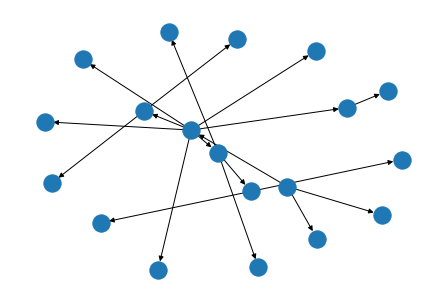

In [275]:
nx.draw(nx.bfs_tree(g, source = 5))

In [276]:
print(len(toTakeArgmax[0]),len(toTakeArgmax))

20 19


In [277]:
finArg = np.argmax(toTakeArgmax,axis=1)

In [278]:
id=-1
mx=-1
for i in range(0,len(finArg)):
    if(toTakeArgmax[i][finArg[i]]>mx):
        mx=toTakeArgmax[i][finArg[i]]
        id=i
clusterNode=gateNodesList[id]

In [279]:
print(clusterNode)

6


In [283]:
partition[clusterNode]
color=partition[clusterNode]
print(partition[clusterNode])

1


In [284]:
print(partition[5])

1


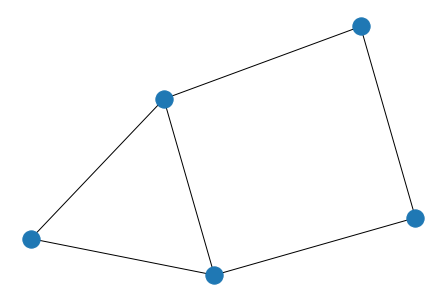

In [285]:
candidateCluster=[]
for e in G.edges():
    if(partition[e[0]]==color and partition[e[1]]==color):
        candidateCluster.append(e)
candidateGraph = nx.Graph()
candidateGraph.add_edges_from(candidateCluster)
nx.draw(candidateGraph)

In [286]:
print(attr)

{}
